In [81]:
# pip install scikit-learn==1.5.1
# pip install xgboost==2.1.1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import xgboost as xgb


In [18]:
# Define locations
locations = ['London', 'Stockholm']

# Define roles for each location
roles = {
    'London': ['Cook', 'Receptionist', 'Waiter'],
    'Stockholm': ['Chef', 'Waiter']
}

# Define business opening days for each location
business_opening_days = {
    'London': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    'Stockholm': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sun']
}

# Define role hours required for each location
role_hours_required = {
    'London': {
        'Mon': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Tue': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Wed': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Thu': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Fri': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12},
        'Sat': {'Cook': 12, 'Receptionist': 12, 'Waiter': 12}
    },
    'Stockholm': {
        'Mon': {'Chef': 12, 'Waiter': 12},
        'Tue': {'Chef': 12, 'Waiter': 12},
        'Wed': {'Chef': 12, 'Waiter': 12},
        'Thu': {'Chef': 12, 'Waiter': 12},
        'Fri': {'Chef': 12, 'Waiter': 12},
        'Sun': {'Chef': 12, 'Waiter': 12}
    }
}

# Define employee roles for each location
employee_roles = {
    'London': {
        'Alice': ['Cook'],
        'Mark': ['Receptionist'],
        'Bob': ['Waiter']
    },
    'Stockholm': {
        'Susan': ['Chef'],
        'Charlie': ['Waiter']
    }
}

# Define employee contracted hours for each location
employee_contracted_hours = {
    'London': {
        'Alice': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0},
        'Mark': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0},
        'Bob': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sat': 0}
    },
    'Stockholm': {
        'Susan': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sun': 0},
        'Charlie': {'Mon': 8, 'Tue': 8, 'Wed': 8, 'Thu': 8, 'Fri': 8, 'Sun': 0}
    }
}

# Define opening hours for each location
opening_hours = {
    'London': {
        'Mon': {'Start': '08:00', 'End': '20:00'},
        'Tue': {'Start': '08:00', 'End': '20:00'},
        'Wed': {'Start': '08:00', 'End': '20:00'},
        'Thu': {'Start': '08:00', 'End': '20:00'},
        'Fri': {'Start': '08:00', 'End': '20:00'},
        'Sat': {'Start': '08:00', 'End': '20:00'},
    },
    'Stockholm': {
        'Mon': {'Start': '09:00', 'End': '21:00'},
        'Tue': {'Start': '09:00', 'End': '21:00'},
        'Wed': {'Start': '09:00', 'End': '21:00'},
        'Thu': {'Start': '09:00', 'End': '21:00'},
        'Fri': {'Start': '09:00', 'End': '21:00'},
        'Sun': {'Start': '10:00', 'End': '22:00'}
    }
}

In [19]:
# Updated scheduling function
def multi_location_schedule(locations: list[str], 
                            business_opening_days: dict[str, list[str]], 
                            roles: dict[str, list[str]], 
                            role_hours_required: dict[str, dict[str, dict[str, int]]], 
                            employee_contracted_hours: dict[str, dict[str, dict[str, int]]], 
                            employee_roles: dict[str, dict[str, list[str]]],
                            business_hour_max: int = 12, 
                            business_days_max: int = 7):
    """
    Schedules employees for different roles on various days while minimizing uncovered hours for multiple locations.
    
    Parameters:
    - locations (list of str): List of business locations.
    - business_opening_days (dict of {str: list of str}): Mapping of locations to their opening days.
    - roles (dict of {str: list of str}): Mapping of locations to roles.
    - role_hours_required (dict of {str: dict of {str: dict of {str: int}}}): Mapping of locations to days to roles to required hours.
    - employee_contracted_hours (dict of {str: dict of {str: dict of {str: int}}}): Mapping of locations to employees to days to their contracted working hours.
    - employee_roles (dict of {str: dict of {str: list of str}}): Mapping of locations to employee names to their roles.
    - business_hour_max (int, optional): Maximum hours any employee can work in a day. Default is 12.
    - business_days_max (int, optional): Maximum days an employee can work in a week. Default is 7.
    
    Returns:
    - schedules (dict of {str: dict of {str: dict of {str: dict of {str: int}}}}): Scheduled hours for each location, employee, day, and role.
    - uncovered_results (dict of {str: dict of {str: dict of {str: int}}}): Uncovered hours for each location, day, and role.
    - total_uncovered (int): Total number of uncovered hours.
    """
    schedules = {}
    uncovered_results = {}
    total_uncovered = 0
    
    for location in locations:
        # Filter employees based on location
        available_employees = list(employee_roles[location].keys())
        
        # Initialize the model for each location
        schedule_problem = LpProblem(f"Employee Scheduling for {location}", LpMinimize)

        # Create decision variables for max hours "business_hour_max" worked by each employee in each role on each day
        x = LpVariable.dicts("work", 
                             ((e, r, d) for e in available_employees for r in roles[location] for d in business_opening_days[location]), 
                             lowBound=0, upBound=business_hour_max, cat='Integer')  

        # Binary variable to indicate if an employee works in a role on a given day
        y = LpVariable.dicts("working_day", 
                             ((e, d) for e in available_employees for d in business_opening_days[location]), 
                             cat='Binary')

        # Create variables for uncovered hours for each role
        uncovered_hours = LpVariable.dicts("uncovered", 
                                           ((r, d) for r in roles[location] for d in business_opening_days[location]), 
                                           lowBound=0, cat='Integer')

        # Objective function: Minimize the total number of uncovered role hours
        schedule_problem += lpSum([uncovered_hours[r, d] for r in roles[location] for d in business_opening_days[location]])

        # Constraints
        for d in business_opening_days[location]:
            for r in roles[location]:
                # Ensure the required role hours are covered or accounted as uncovered
                schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[location][e]]) \
                      + uncovered_hours[r, d] == role_hours_required[location][d][r]

                # Ensure the total hours assigned do not exceed role_hours_required
                schedule_problem += lpSum([x[e, r, d] for e in available_employees if r in employee_roles[location][e]]) <= role_hours_required[location][d][r]

        for e in available_employees:
            for d in business_opening_days[location]:
                # Use the daily maximum hours for each employee
                max_hours = employee_contracted_hours[location][e][d]

                # Ensure each employee works at most their maximum hours per day across all roles
                schedule_problem += lpSum([x[e, r, d] for r in roles[location]]) <= max_hours

                for r in roles[location]:
                    # Link binary variable with hours worked (if working, y = 1; otherwise, y = 0)
                    schedule_problem += x[e, r, d] <= y[e, d] * max_hours

            # Ensure each employee works at most "business_days_max" days per week
            schedule_problem += lpSum([y[e, d] for d in business_opening_days[location]]) <= business_days_max

        # Solve the model with verbose output turned off
        schedule_problem.solve(PULP_CBC_CMD(msg=False))

        # Prepare results for each location
        schedules[location] = {}
        uncovered_results[location] = {}

        for e in available_employees:
            schedules[location][e] = {}
            for d in business_opening_days[location]:
                schedules[location][e][d] = {}
                for r in roles[location]:
                    hours = x[e, r, d].value()
                    if hours > 0:
                        schedules[location][e][d][r] = hours

        for d in business_opening_days[location]:
            uncovered_results[location][d] = {}
            for r in roles[location]:
                uncovered = uncovered_hours[r, d].value()
                uncovered_results[location][d][r] = uncovered
                total_uncovered += uncovered

    return schedules, uncovered_results, total_uncovered

In [70]:
def assign_working_hours(schedules, opening_hours, coverage_preference="start"):
    """
    Assigns working hours to employees based on the schedule results and business opening hours for each location.
    
    Parameters:
    - schedules: dict
        The schedule results with hours each employee will work each day for each role for each location.
    - opening_hours: dict
        The opening hours for each day for each location.
    - coverage_preference: str, optional
        The preference for covering hours: "start", "middle", "end". Default is "start".
    
    Returns:
    - working_hours: dict
        Dictionary with employees' working hours assigned based on opening hours and coverage preference for each location.
    """
    def format_time(time):
        return time.strftime('%H:%M')

    def calculate_working_hours(start_time, hours, preference):
        end_time = start_time + timedelta(hours=hours)
        return format_time(start_time), format_time(end_time)

    working_hours = {}

    for location in schedules:
        working_hours[location] = {}

        for e in schedules[location]:
            working_hours[location][e] = {}
            
            for d in schedules[location][e]:
                if d not in working_hours[location][e]:
                    working_hours[location][e][d] = {}

                # Get the opening and closing times for this location and day
                start_time = datetime.strptime(opening_hours[location][d]['Start'], '%H:%M')
                end_time = datetime.strptime(opening_hours[location][d]['End'], '%H:%M')
                business_duration = (end_time - start_time).total_seconds() / 3600

                for r in schedules[location][e][d]:
                    hours = schedules[location][e][d][r]
                    if hours <= 0:
                        continue

                    # Determine the start and end time based on coverage preference
                    if coverage_preference == "start":
                        start, end = calculate_working_hours(start_time, hours, "start")
                    elif coverage_preference == "end":
                        start, end = calculate_working_hours(end_time - timedelta(hours=hours), hours, "end")
                    elif coverage_preference == "middle":
                        middle_start = start_time + timedelta(hours=(business_duration - hours) / 2)
                        start, end = calculate_working_hours(middle_start, hours, "middle")
                    else:
                        raise ValueError("Invalid coverage preference. Choose from 'start', 'middle', 'end'.")

                    working_hours[location][e][d][r] = {
                        "Start": start,
                        "End": end
                    }

    return working_hours



# Run the assign working hours function
working_hours = assign_working_hours(schedules, opening_hours, coverage_preference="start")

# Extract and print the working hours
print("\nAssigned Working Hours:")
for location in working_hours:
    print(f"\nLocation: {location}")
    for e in working_hours[location]:
        print(f"\n  Working hours for {e}:")
        for d in working_hours[location][e]:
            for r in working_hours[location][e][d]:
                start = working_hours[location][e][d][r]["Start"]
                end = working_hours[location][e][d][r]["End"]
                print(f"    {d} - {r}: {start} to {end}")


Assigned Working Hours:

Location: London

  Working hours for Alice:
    Mon - Cook: 08:00 to 16:00
    Tue - Cook: 08:00 to 16:00
    Wed - Cook: 08:00 to 16:00
    Thu - Cook: 08:00 to 16:00
    Fri - Cook: 08:00 to 16:00

  Working hours for Mark:
    Mon - Receptionist: 08:00 to 16:00
    Tue - Receptionist: 08:00 to 16:00
    Wed - Receptionist: 08:00 to 16:00
    Thu - Receptionist: 08:00 to 16:00
    Fri - Receptionist: 08:00 to 16:00

  Working hours for Bob:
    Mon - Waiter: 08:00 to 16:00
    Tue - Waiter: 08:00 to 16:00
    Wed - Waiter: 08:00 to 16:00
    Thu - Waiter: 08:00 to 16:00
    Fri - Waiter: 08:00 to 16:00

Location: Stockholm

  Working hours for Susan:
    Mon - Chef: 09:00 to 17:00
    Tue - Chef: 09:00 to 17:00
    Wed - Chef: 09:00 to 17:00
    Thu - Chef: 09:00 to 17:00
    Fri - Chef: 09:00 to 17:00

  Working hours for Charlie:
    Mon - Waiter: 09:00 to 17:00
    Tue - Waiter: 09:00 to 17:00
    Wed - Waiter: 09:00 to 17:00
    Thu - Waiter: 09:00 to 1

In [20]:
# Run the scheduler for multiple locations
schedules, uncovered_results, total_uncovered = multi_location_schedule(
    locations,
    business_opening_days,
    roles,
    role_hours_required,
    employee_contracted_hours,
    employee_roles
)

In [40]:
schedules

{'London': {'Alice': {'Mon': {'Cook': 8.0},
   'Tue': {'Cook': 8.0},
   'Wed': {'Cook': 8.0},
   'Thu': {'Cook': 8.0},
   'Fri': {'Cook': 8.0},
   'Sat': {}},
  'Mark': {'Mon': {'Receptionist': 8.0},
   'Tue': {'Receptionist': 8.0},
   'Wed': {'Receptionist': 8.0},
   'Thu': {'Receptionist': 8.0},
   'Fri': {'Receptionist': 8.0},
   'Sat': {}},
  'Bob': {'Mon': {'Waiter': 8.0},
   'Tue': {'Waiter': 8.0},
   'Wed': {'Waiter': 8.0},
   'Thu': {'Waiter': 8.0},
   'Fri': {'Waiter': 8.0},
   'Sat': {}}},
 'Stockholm': {'Susan': {'Mon': {'Chef': 8.0},
   'Tue': {'Chef': 8.0},
   'Wed': {'Chef': 8.0},
   'Thu': {'Chef': 8.0},
   'Fri': {'Chef': 8.0},
   'Sun': {}},
  'Charlie': {'Mon': {'Waiter': 8.0},
   'Tue': {'Waiter': 8.0},
   'Wed': {'Waiter': 8.0},
   'Thu': {'Waiter': 8.0},
   'Fri': {'Waiter': 8.0},
   'Sun': {}}}}

## XGBoost - Data Processing

In [107]:
# Function to generate synthetic revenue data based on schedules
def generate_synthetic_data(schedules, uncovered_results):
    data = []

    for location in schedules:
        for employee, employee_schedule in schedules[location].items():
            for day, day_schedule in employee_schedule.items():
                for role, hours in day_schedule.items():
                    # Generate a synthetic revenue value
                    # Assume each hour contributes to revenue between 20-50 units, reduced by uncovered hours
                    uncovered_hours = uncovered_results[location].get(day, {}).get(role, 0)
                    revenue = hours * uniform(20, 50) - uncovered_hours * uniform(10, 30)

                    data.append({
                        'Location': location,
                        'Employee': employee,
                        'Day': day,
                        'Role': role,
                        'Hours': hours,
                        'Uncovered': uncovered_hours,
                        'Revenue': max(0, revenue)  # Ensure revenue isn't negative
                    })

    return pd.DataFrame(data)

# Generate synthetic dataset
schedule_data = generate_synthetic_data(schedules, uncovered_results)

# Display the dataset
schedule_data

,Location,Employee,Day,Role,Hours,Uncovered,Revenue
0,London,Alice,Mon,Cook,8.0,4.0,259.392281
1,London,Alice,Tue,Cook,8.0,4.0,209.159554
2,London,Alice,Wed,Cook,8.0,4.0,143.152291
3,London,Alice,Thu,Cook,8.0,4.0,141.761167
4,London,Alice,Fri,Cook,8.0,4.0,141.217224
5,London,Mark,Mon,Receptionist,8.0,4.0,287.908144
6,London,Mark,Tue,Receptionist,8.0,4.0,297.811660
7,London,Mark,Wed,Receptionist,8.0,4.0,291.942952
8,London,Mark,Thu,Receptionist,8.0,4.0,305.780109
9,London,Mark,Fri,Receptionist,8.0,4.0,270.615780


In [95]:
# Feature Engineering Function
def add_features_with_working_hours(df, working_hours, schedules, role_hours_required):
    # Initialize lists to store calculated features
    total_employee_hours = []
    total_role_hours = []
    utilization_rate = []
    role_coverage_ratio = []
    day_type = []
    peak_hours_flag = []
    shift_start_time = []
    shift_end_time = []
    shift_duration = []
    coverage_gaps = []
    coverage_preference_encoded = []

    # Define coverage preference mapping
    coverage_preference_mapping = {"start": 0, "middle": 1, "end": 2}

    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        location = row['Location']
        employee = row['Employee']
        day = row['Day']
        role = row['Role']
        hours = row['Hours']

        # Total employee hours for the day
        employee_hours = sum(schedules[location][employee][day].values())
        total_employee_hours.append(employee_hours)

        # Total role hours for the day
        role_hours = sum(
            schedule_data[
                (schedule_data['Location'] == location) & 
                (schedule_data['Day'] == day) & 
                (schedule_data['Role'] == role)
            ]['Hours']
        )
        total_role_hours.append(role_hours)

        # Utilization rate
        contracted_hours = employee_contracted_hours[location][employee][day]
        utilization = hours / contracted_hours if contracted_hours > 0 else 0
        utilization_rate.append(utilization)

        # Role coverage ratio
        required_hours = role_hours_required[location][day][role]
        coverage_ratio = hours / required_hours
        role_coverage_ratio.append(coverage_ratio)

        # Day type
        if day in ['Sat', 'Sun']:
            day_type.append('Weekend')
        else:
            day_type.append('Weekday')

        # Peak hours flag (for example, assume peak hours between 12:00 to 14:00)
        start_hour = int(opening_hours[location][day]['Start'].split(':')[0])
        end_hour = int(opening_hours[location][day]['End'].split(':')[0])
        if start_hour <= 12 <= end_hour or start_hour <= 14 <= end_hour:
            peak_hours_flag.append(1)  # Flag as peak hours
        else:
            peak_hours_flag.append(0)  # Not peak hours

        # Shift start and end times
        shift_start = working_hours[location][employee][day][role]["Start"]
        shift_end = working_hours[location][employee][day][role]["End"]
        shift_start_time.append(shift_start)
        shift_end_time.append(shift_end)

        # Shift duration in hours
        shift_start_dt = datetime.strptime(shift_start, '%H:%M')
        shift_end_dt = datetime.strptime(shift_end, '%H:%M')
        duration = (shift_end_dt - shift_start_dt).total_seconds() / 3600
        shift_duration.append(duration)

        # Coverage gaps (example: assume gaps between shifts on the same day)
        if index > 0 and df.loc[index-1, 'Employee'] == employee and df.loc[index-1, 'Day'] == day:
            prev_end_time = datetime.strptime(df.loc[index-1, 'End'], '%H:%M')
            gap = (shift_start_dt - prev_end_time).total_seconds() / 3600
        else:
            gap = 0
        coverage_gaps.append(gap)

        # Coverage preference encoding
        coverage_preference = "start"  # Assuming 'start' for simplicity; replace with actual preference if available
        coverage_preference_encoded.append(coverage_preference_mapping[coverage_preference])

    # Add new features to the DataFrame
    df['Total_Employee_Hours'] = total_employee_hours
    df['Total_Role_Hours'] = total_role_hours
    df['Utilization_Rate'] = utilization_rate
    df['Role_Coverage_Ratio'] = role_coverage_ratio
    df['Day_Type'] = day_type
    df['Peak_Hours'] = peak_hours_flag
    df['Shift_Start_Time'] = shift_start_time
    df['Shift_End_Time'] = shift_end_time
    df['Shift_Duration'] = shift_duration
    df['Coverage_Gaps'] = coverage_gaps
    df['Coverage_Preference'] = coverage_preference_encoded

    # Move the 'Revenue' column to the last position
    revenue = df.pop('Revenue')
    df['Revenue'] = revenue

    return df

# Generate synthetic dataset
schedule_data = generate_synthetic_data(schedules, uncovered_results)

# Assign working hours
working_hours = assign_working_hours(schedules, opening_hours, coverage_preference="start")

# Apply feature engineering to the schedule data with working hours
enhanced_schedule_data = add_features_with_working_hours(schedule_data, working_hours, schedules, role_hours_required)

# Display the enhanced dataset with new features
enhanced_schedule_data


,Location,Employee,Day,Role,Hours,Uncovered,Total_Employee_Hours,Total_Role_Hours,Utilization_Rate,Role_Coverage_Ratio,Day_Type,Peak_Hours,Shift_Start_Time,Shift_End_Time,Shift_Duration,Coverage_Gaps,Coverage_Preference,Revenue
0,London,Alice,Mon,Cook,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,150.533065
1,London,Alice,Tue,Cook,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,252.645158
2,London,Alice,Wed,Cook,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,45.283445
3,London,Alice,Thu,Cook,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,55.983974
4,London,Alice,Fri,Cook,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,278.471070
5,London,Mark,Mon,Receptionist,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,211.567797
6,London,Mark,Tue,Receptionist,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,278.473299
7,London,Mark,Wed,Receptionist,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,150.481371
8,London,Mark,Thu,Receptionist,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,344.065845
9,London,Mark,Fri,Receptionist,8.0,4.0,8.0,8.0,1.0,0.666667,Weekday,1,08:00,16:00,8.0,0,0,126.083022


## Train Model on Rows 
Predicts how good of a choice a single slot is


In [98]:
# Define features and target
features = enhanced_schedule_data.drop('Revenue', axis=1)
target = enhanced_schedule_data['Revenue']

# Define transformations
transformer = make_column_transformer(
 (OneHotEncoder(), ['Location', 'Employee', 'Role', 'Day']),
    (StandardScaler(), ['Hours', 'Uncovered', 'Total_Employee_Hours', 'Total_Role_Hours', 'Utilization_Rate', 'Role_Coverage_Ratio', 'Peak_Hours', 'Shift_Duration', 'Coverage_Gaps', 'Coverage_Preference'])
    )

# Transform features
pipeline = Pipeline(steps=[('transformer', transformer)])
features_transformed = pipeline.fit_transform(features)

# Extract feature names from the pipeline
feature_names = pipeline.named_steps['transformer'].get_feature_names_out()

# Convert to dense array if necessary
if hasattr(features_transformed, "toarray"):
    features_transformed = features_transformed.toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_transformed, target, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(feature_names))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(feature_names))

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_boost_round = 100
model = xgb.train(params, dtrain, num_boost_round)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model
mse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Root Mean Squared Error: 98.4425
R^2 Score: -1.4131


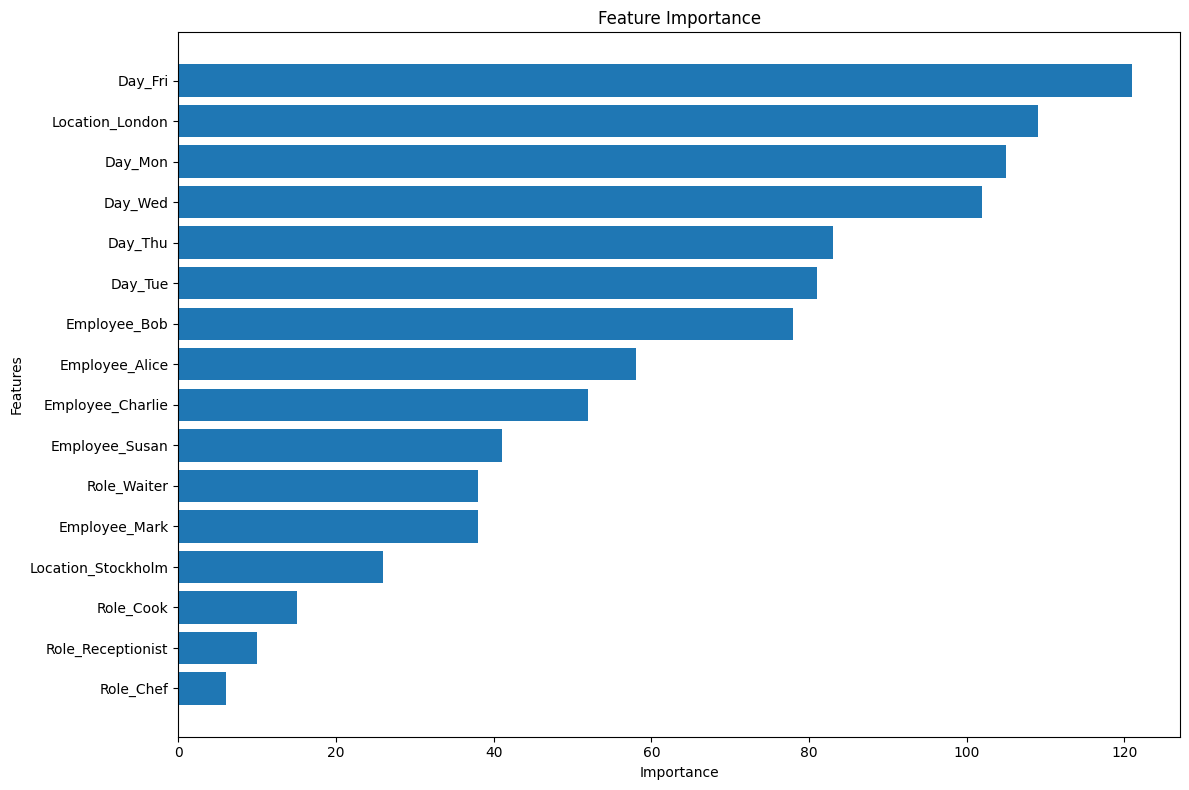

In [75]:
# Feature Importance with actual feature names
importance = model.get_score(importance_type='weight')
importance = {k.split('__')[-1]: v for k, v in importance.items()}  # Clean feature names
importance = dict(sorted(importance.items(), key=lambda item: item[1]))  # Sort in ascending order

plt.figure(figsize=(12, 8))
plt.barh(list(importance.keys()), list(importance.values()))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Train Model on Weeks
Predicts how good an entire weekly schedule is 

In [99]:
# Function to aggregate data by week
def aggregate_weekly_data(df):
    # Convert the day names to datetime objects for easier aggregation
    df['Day'] = pd.to_datetime(df['Day'] + ' 2024', format='%a %Y').dt.strftime('%Y-%U')  # Week of the year

    # Group by location, employee, role, and week
    weekly_data = df.groupby(['Location', 'Employee', 'Role', 'Day']).agg({
        'Hours': 'sum',
        'Uncovered': 'sum',
        'Revenue': 'sum',
        'Total_Employee_Hours': 'sum',
        'Total_Role_Hours': 'sum',
        'Utilization_Rate': 'mean',
        'Role_Coverage_Ratio': 'mean',
        'Peak_Hours': 'sum',
        'Shift_Duration': 'sum',
        'Coverage_Gaps': 'sum',
        'Coverage_Preference': 'mean'
    }).reset_index()

    return weekly_data

# Aggregate the data
weekly_schedule_data = aggregate_weekly_data(enhanced_schedule_data)

In [100]:
weekly_schedule_data

,Location,Employee,Role,Day,Hours,Uncovered,Revenue,Total_Employee_Hours,Total_Role_Hours,Utilization_Rate,Role_Coverage_Ratio,Peak_Hours,Shift_Duration,Coverage_Gaps,Coverage_Preference
0,London,Alice,Cook,2024-00,40.0,20.0,782.916712,40.0,40.0,1.0,0.666667,5,40.0,0,0.0
1,London,Bob,Waiter,2024-00,40.0,20.0,1188.006290,40.0,40.0,1.0,0.666667,5,40.0,0,0.0
2,London,Mark,Receptionist,2024-00,40.0,20.0,1110.671334,40.0,40.0,1.0,0.666667,5,40.0,0,0.0
3,Stockholm,Charlie,Waiter,2024-00,40.0,20.0,1052.154452,40.0,40.0,1.0,0.666667,5,40.0,0,0.0
4,Stockholm,Susan,Chef,2024-00,40.0,20.0,1013.375248,40.0,40.0,1.0,0.666667,5,40.0,0,0.0


In [101]:
# Define features and target for weekly data
features_weekly = weekly_schedule_data.drop('Revenue', axis=1)
target_weekly = weekly_schedule_data['Revenue']

In [102]:
# Define transformations for weekly data
transformer_weekly = make_column_transformer(
    (OneHotEncoder(), ['Location', 'Employee', 'Role', 'Day']),
    (StandardScaler(), ['Hours', 'Uncovered', 'Total_Employee_Hours', 'Total_Role_Hours', 'Utilization_Rate', 'Role_Coverage_Ratio', 'Peak_Hours', 'Shift_Duration', 'Coverage_Gaps', 'Coverage_Preference'])
)

# Transform features
pipeline_weekly = Pipeline(steps=[('transformer', transformer_weekly)])
features_transformed_weekly = pipeline_weekly.fit_transform(features_weekly)

# Extract feature names from the pipeline
feature_names_weekly = pipeline_weekly.named_steps['transformer'].get_feature_names_out()

# Convert to dense array if necessary
if hasattr(features_transformed_weekly, "toarray"):
    features_transformed_weekly = features_transformed_weekly.toarray()

# Split the data
X_train_weekly, X_test_weekly, y_train_weekly, y_test_weekly = train_test_split(features_transformed_weekly, target_weekly, test_size=0.2, random_state=42)


In [106]:
# Create DMatrix for XGBoost
dtrain_weekly = xgb.DMatrix(X_train_weekly, label=y_train_weekly, feature_names=list(feature_names_weekly))
dtest_weekly = xgb.DMatrix(X_test_weekly, label=y_test_weekly, feature_names=list(feature_names_weekly))

# Define parameters for XGBoost
params_weekly = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_boost_round_weekly = 100
model_weekly = xgb.train(params_weekly, dtrain_weekly, num_boost_round_weekly)

# Make predictions on the test set
predictions_weekly = model_weekly.predict(dtest_weekly)

# Evaluate the model
mse_weekly = np.sqrt(mean_squared_error(y_test_weekly, predictions_weekly))
r2_weekly = r2_score(y_test_weekly, predictions_weekly)

print(f"Root Mean Squared Error: {mse_weekly:.4f}")
print(f"R^2 Score: {r2_weekly:.4f}")


Root Mean Squared Error: 105.8798
R^2 Score: nan


/home/alessandro/miniconda3/envs/hack/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


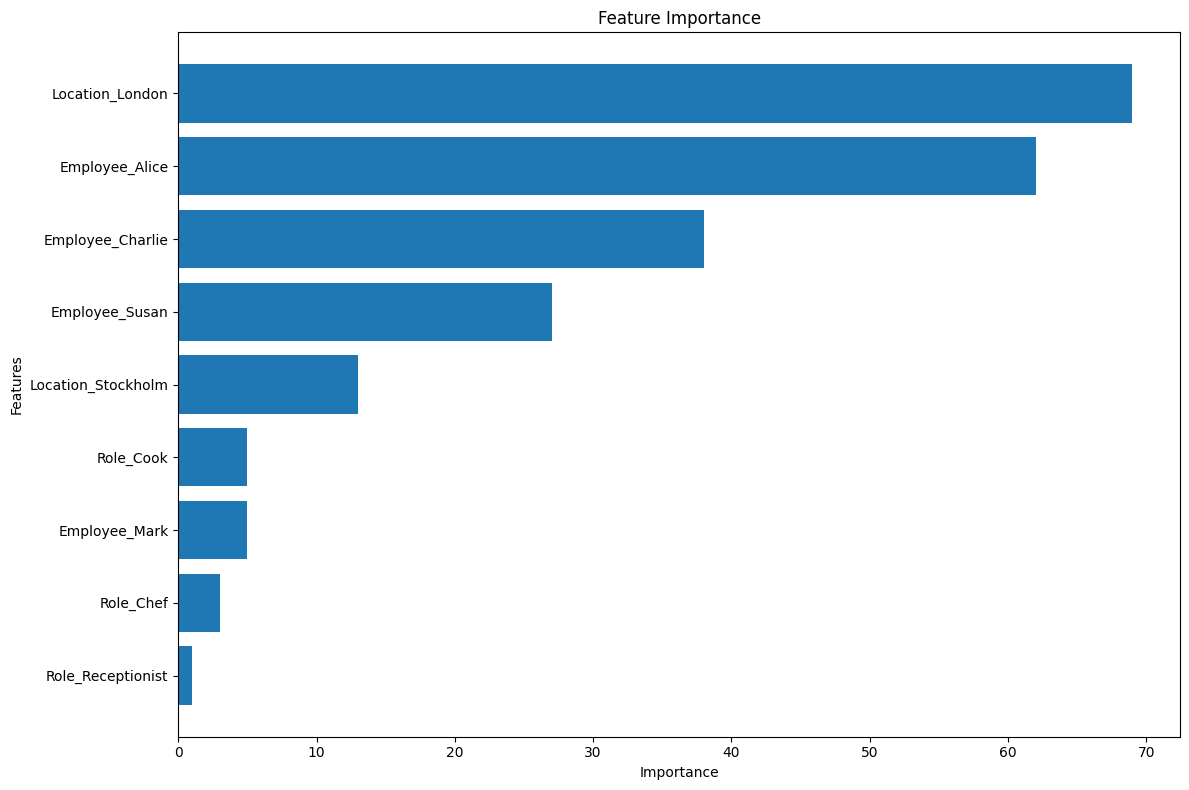

In [105]:
# Feature Importance with actual feature names
importance = model_weekly.get_score(importance_type='weight')
importance = {k.split('__')[-1]: v for k, v in importance.items()}  # Clean feature names
importance = dict(sorted(importance.items(), key=lambda item: item[1]))  # Sort in ascending order

plt.figure(figsize=(12, 8))
plt.barh(list(importance.keys()), list(importance.values()))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()